In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [2]:
df=pd.read_csv("clean_baseline.csv",sep=';',dtype = {'Libelle': str},parse_dates=['Date et heure de comptage'])
df.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,0,1,0,0,0,0,1
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,0,1,0,0,0,0,1
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,0,0,0,0,1,0,1
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,0,0,0,0,1,0,1
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,0,1,0,0,0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27548 entries, 0 to 27547
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Libelle                    27548 non-null  object        
 1   Date et heure de comptage  27548 non-null  datetime64[ns]
 2   Débit horaire              27548 non-null  float64       
 3   Taux d'occupation          27548 non-null  float64       
 4   Etat trafic_Bloqué         27548 non-null  int64         
 5   Etat trafic_Fluide         27548 non-null  int64         
 6   Etat trafic_Inconnu        27548 non-null  int64         
 7   Etat trafic_Pré-saturé     27548 non-null  int64         
 8   Etat trafic_Saturé         27548 non-null  int64         
 9   Etat arc_Barré             27548 non-null  int64         
 10  Etat arc_Invalide          27548 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(1)
memory usage:

In [4]:
df = df.sort_values("Date et heure de comptage")
df.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide
9309,Convention,2021-11-01 04:00:00,145.0,0.91611,0,1,0,0,0,0,1
25765,Sts_Peres,2021-11-01 04:00:00,163.0,1.94556,0,1,0,0,0,0,1
157,AV_Champs_Elysees,2021-11-01 04:00:00,1222.0,42.87945,0,0,0,0,1,0,1
18607,Sts_Peres,2021-11-01 05:00:00,125.0,1.67778,0,1,0,0,0,0,1
16652,Convention,2021-11-01 05:00:00,127.0,0.76222,0,1,0,0,0,0,1


In [5]:
df_conv=df[df["Libelle"]=="Convention"].drop('Libelle',axis=1)
df_stp=df[df["Libelle"]=="Sts_Peres"].drop('Libelle',axis=1)
df_ace=df[df["Libelle"]=="AV_Champs_Elysees"].drop('Libelle',axis=1)

# Working on df_stp

In [6]:
df_stp.columns=[name.lower().replace(' ','_') for name in df_stp.columns]

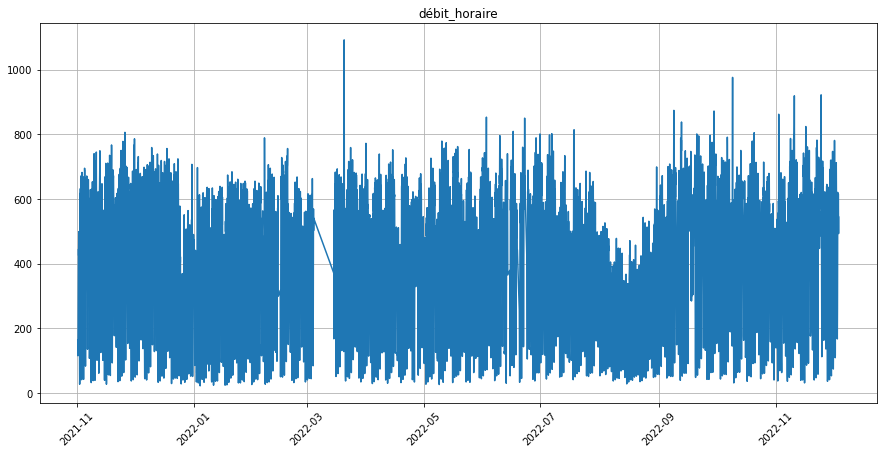

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(df_stp.date_et_heure_de_comptage,df_stp.débit_horaire)    
plt.xticks(rotation=45)
plt.title('débit_horaire')
plt.grid(True)
plt.show()

In [8]:
df_stp=df_stp.set_index('date_et_heure_de_comptage')
df_stp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9164 entries, 2021-11-01 04:00:00 to 2022-12-04 00:00:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   débit_horaire           9164 non-null   float64
 1   taux_d'occupation       9164 non-null   float64
 2   etat_trafic_bloqué      9164 non-null   int64  
 3   etat_trafic_fluide      9164 non-null   int64  
 4   etat_trafic_inconnu     9164 non-null   int64  
 5   etat_trafic_pré-saturé  9164 non-null   int64  
 6   etat_trafic_saturé      9164 non-null   int64  
 7   etat_arc_barré          9164 non-null   int64  
 8   etat_arc_invalide       9164 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 715.9 KB


## Split 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

y = df_stp.débit_horaire
X = df_stp.drop(['débit_horaire'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

## Utils

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return math.sqrt(mean_absolute_percentage_error(y_true, y_pred))

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    rmse=math.sqrt(error)
    #plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.title("RMSE {0:.2f}%".format(rmse))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    

def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

## LinearRegressor

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

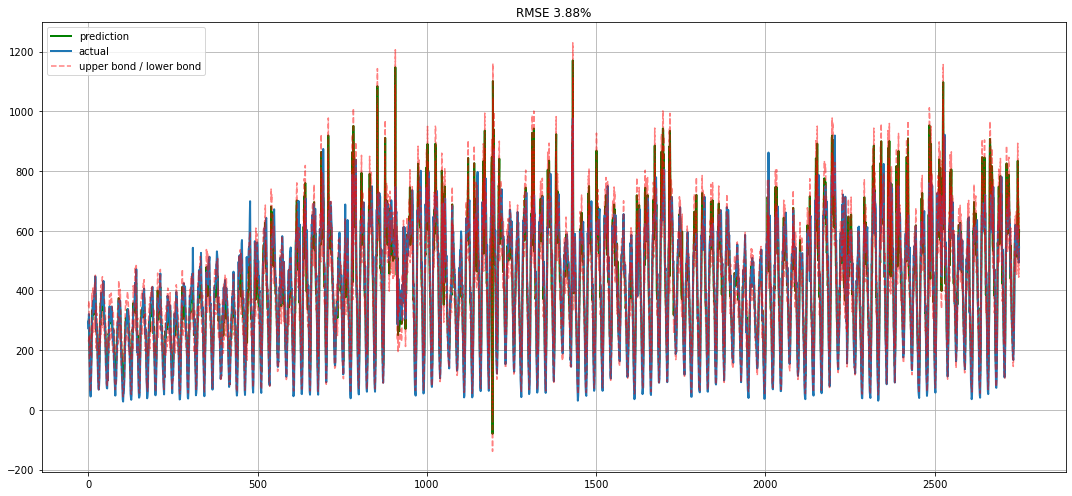

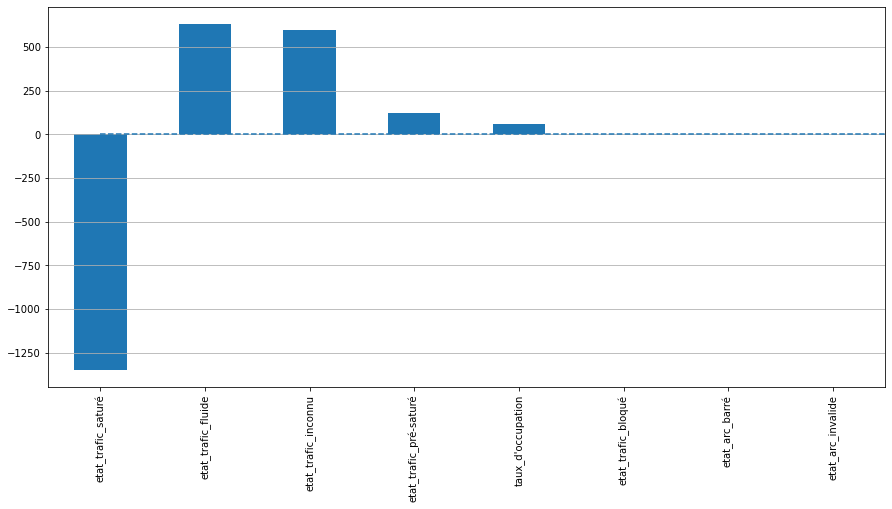

In [12]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

## XGB

In [13]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

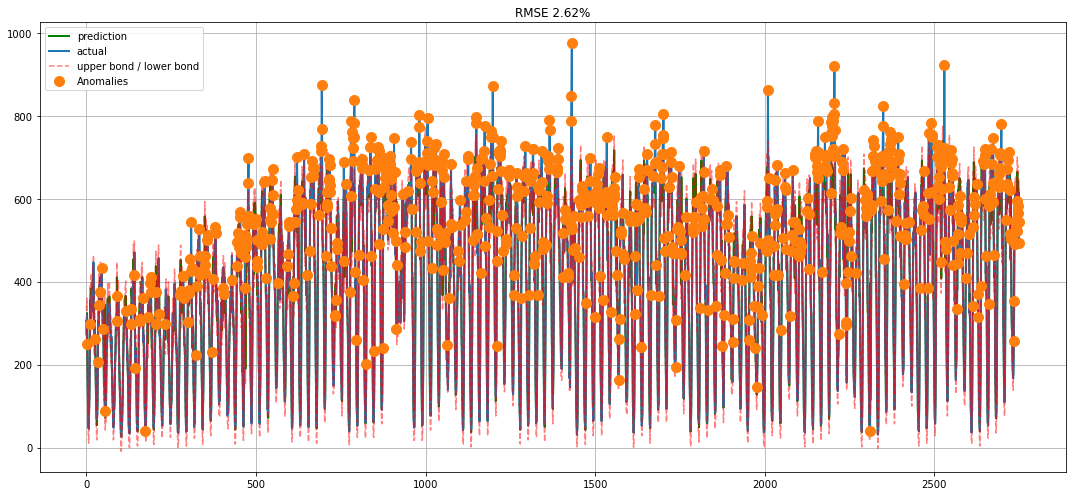

In [14]:
plotModelResults(xgb, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)

## Prophet

In [28]:
from prophet import Prophet

In [37]:
df_stp.head()

,date_et_heure_de_comptage,débit_horaire,taux_d'occupation,etat_trafic_bloqué,etat_trafic_fluide,etat_trafic_inconnu,etat_trafic_pré-saturé,etat_trafic_saturé,etat_arc_barré,etat_arc_invalide
0,2021-11-01 04:00:00,163.0,1.94556,0,1,0,0,0,0,1
1,2021-11-01 05:00:00,125.0,1.67778,0,1,0,0,0,0,1
2,2021-11-01 06:00:00,115.0,1.58444,0,1,0,0,0,0,1
3,2021-11-01 07:00:00,129.0,1.56222,0,1,0,0,0,0,1
4,2021-11-01 08:00:00,144.0,1.94278,0,1,0,0,0,0,1


In [40]:
df_stp_prophet=df_stp[["date_et_heure_de_comptage","débit_horaire"]].rename(columns={"date_et_heure_de_comptage":"ds","débit_horaire":"y"})
df_stp_prophet.head()

,ds,y
0,2021-11-01 04:00:00,163.0
1,2021-11-01 05:00:00,125.0
2,2021-11-01 06:00:00,115.0
3,2021-11-01 07:00:00,129.0
4,2021-11-01 08:00:00,144.0
...,...,...
9159,2022-12-03 20:00:00,615.0
9160,2022-12-03 21:00:00,582.0
9161,2022-12-03 22:00:00,566.0
9162,2022-12-03 23:00:00,493.0


01:18:39 - cmdstanpy - INFO - Chain [1] start processing
01:18:42 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'stp_forecast')

<Figure size 1296x432 with 0 Axes>

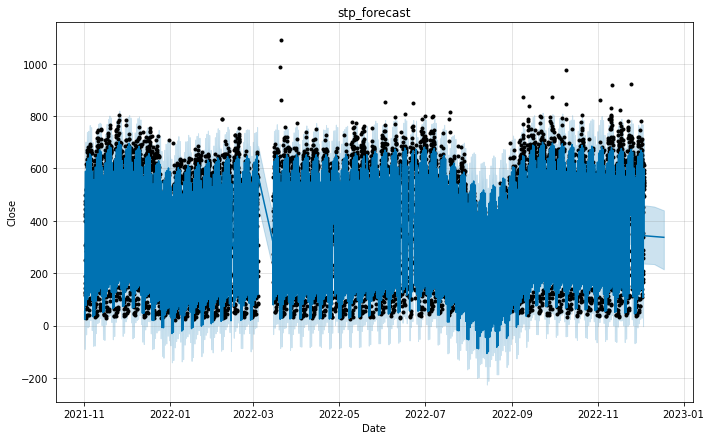

In [45]:
model = Prophet()
model.fit(df_stp_prophet)
stp_forecast = model.make_future_dataframe(periods=2, freq='w')
stp_forecast = model.predict(stp_forecast)
plt.figure(figsize=(18, 6))
model.plot(stp_forecast, xlabel = 'Date', ylabel = 'Close')
plt.title('stp_forecast')

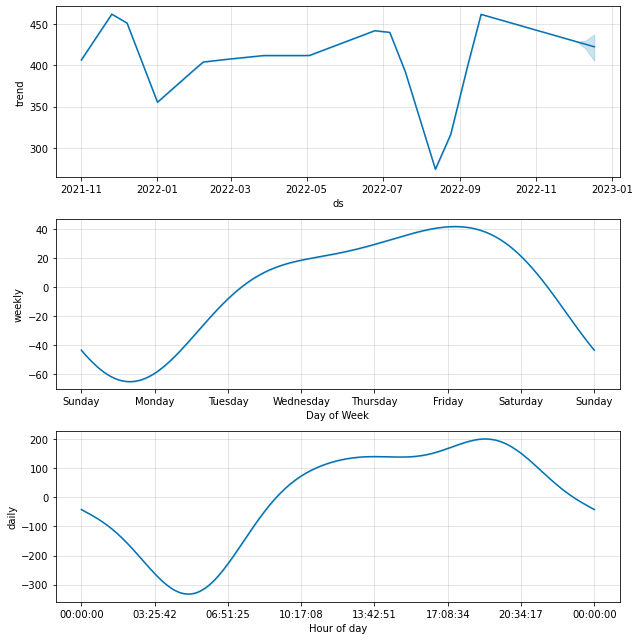

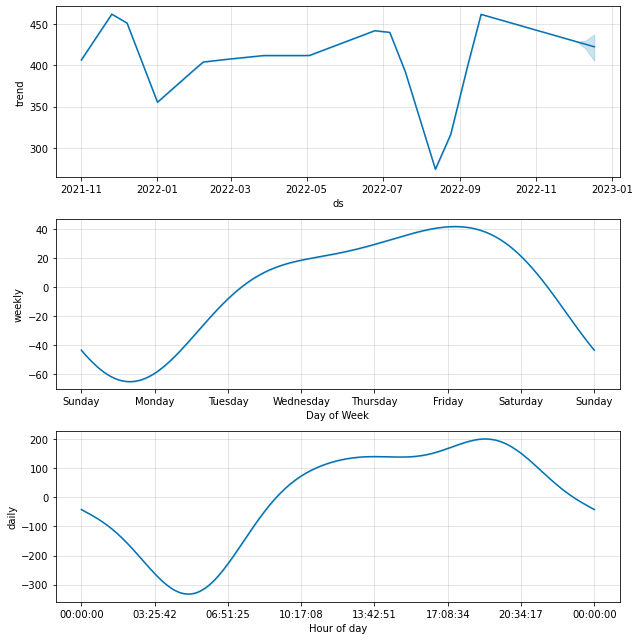

In [47]:
model.plot_components(stp_forecast)

In [46]:
stp_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-11-01 04:00:00,406.393260,-58.096817,159.036147,406.393260,406.393260,-354.176056,-354.176056,-354.176056,-301.080681,-301.080681,-301.080681,-53.095375,-53.095375,-53.095375,0.0,0.0,0.0,52.217204
1,2021-11-01 05:00:00,406.487872,-89.209495,134.309516,406.487872,406.487872,-383.443782,-383.443782,-383.443782,-332.264511,-332.264511,-332.264511,-51.179271,-51.179271,-51.179271,0.0,0.0,0.0,23.044090
2,2021-11-01 06:00:00,406.582485,-52.403913,167.950302,406.582485,406.582485,-349.244235,-349.244235,-349.244235,-300.078084,-300.078084,-300.078084,-49.166151,-49.166151,-49.166151,0.0,0.0,0.0,57.338250
3,2021-11-01 07:00:00,406.677097,36.001272,256.077944,406.677097,406.677097,-261.123388,-261.123388,-261.123388,-214.056952,-214.056952,-214.056952,-47.066436,-47.066436,-47.066436,0.0,0.0,0.0,145.553709
4,2021-11-01 08:00:00,406.771710,145.511664,369.612339,406.771710,406.771710,-151.299085,-151.299085,-151.299085,-106.408329,-106.408329,-106.408329,-44.890756,-44.890756,-44.890756,0.0,0.0,0.0,255.472624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9161,2022-12-03 22:00:00,428.426769,333.170678,572.669054,428.426769,428.426769,20.339420,20.339420,20.339420,58.725060,58.725060,58.725060,-38.385640,-38.385640,-38.385640,0.0,0.0,0.0,448.766188
9162,2022-12-03 23:00:00,428.408777,273.747496,491.515995,428.408777,428.408777,-39.848828,-39.848828,-39.848828,1.181045,1.181045,1.181045,-41.029873,-41.029873,-41.029873,0.0,0.0,0.0,388.559949
9163,2022-12-04 00:00:00,428.390786,236.375302,459.375098,428.390786,428.390786,-85.409046,-85.409046,-85.409046,-41.824310,-41.824310,-41.824310,-43.584737,-43.584737,-43.584737,0.0,0.0,0.0,342.981740
9164,2022-12-11 00:00:00,425.368255,234.818356,454.644743,420.142355,429.713734,-85.409046,-85.409046,-85.409046,-41.824310,-41.824310,-41.824310,-43.584737,-43.584737,-43.584737,0.0,0.0,0.0,339.959209
